In [128]:
import pandas as pd
from yelp.client import Client
from yelp.oauth1_authenticator import Oauth1Authenticator
from haversine import haversine
import numpy as np
import math
import os
import scipy as sp
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 
import datetime
import seaborn as sns
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Circle
import glob
import shapefile
import mpl_toolkits.basemap.pyproj as pyproj
from sklearn import cluster
from IPython import display
from collections import defaultdict
import pickle
%matplotlib inline

In [2]:
dfRest = pd.read_csv("All_Rest.csv")

## First we read in the data

In [3]:
path = "/Volumes/My Passport/Taxi_Data/Yellow_Taxi/Yellow_1/"
path2 = "/Volumes/SP UFD U3/2015 Data/"

In [4]:
cols = ["vendorID", "pickup_datetime", "dropoff_datetime","passenger_count", "trip_distance",\
                          "pickup_long","pickup_lat","rate_code","dropoff_long","dropoff_lat",\
                          "payment_type","fare_amount","surcharge","tip_amount","tolls_amount",\
                          "total_amount"]

In [5]:
def read_data(path,ends_with, cols = cols):
    df1 = []
    for f1 in os.listdir(path):
        if f1.endswith(ends_with):
            if cols is not None:
                df1.append(pd.read_csv(path2 + f1, usecols= cols))
            else:
                df1.append(pd.read_csv(path2 + f1))
    return df1
            #print f1

In [7]:
df = read_data(path2, "01.csv",None)

In [8]:
dfTotal = pd.concat(df)

In [9]:
dfTotal = dfTotal[["dropoff_latitude","dropoff_longitude","pickup_latitude","pickup_longitude","tpep_dropoff_datetime"\
                  ,"tpep_pickup_datetime","trip_distance","RateCodeID"]]

In [10]:
dfTotal.columns = ["dropoff_lat","dropoff_long","pickup_lat","pickup_long", "dropoff_datetime","pickup_datetime",\
                    "trip_distance","rate_code"]

The datetime information in the original dataframe is a string which we split and turn into two datetime obejcts, the date and the time of the pickup.

In [11]:
def convert_datetime(df):
    cols = ["pickup_datetime","dropoff_datetime"]
    for col in cols:
        df.loc[:,col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

In [12]:
convert_datetime(dfTotal)

To make filtering easier we add a year, month and day of week columns to the dataframe. It will also be useful to have a duration column, and to add a time of day category which is determined by the hour of the day.

In [19]:
def add_details(df):
    df.loc[:,"pickup_year"] = df["pickup_datetime"].apply(lambda x: x.year)
    df.loc[:,"pickup_month"] = df["pickup_datetime"].apply(lambda x: x.month)
    df.loc[:,"pickup_day"] = df["pickup_datetime"].apply(lambda x: x.weekday())
    df.loc[:,"duration"] = df["dropoff_datetime"]-df["pickup_datetime"]
    df.loc[:,"time_category_pick"] = df["pickup_datetime"].apply(lambda x: x.hour)
    df.loc[:,"time_category_drop"] = df["dropoff_datetime"].apply(lambda x: x.hour)

In [20]:
add_details(dfTotal)

## This is temporary to add back the pickup and dropoff date-time columns

In [380]:
lenT = dfTotal.shape[0]

In [389]:
dfTotal["pickup_datetime"] = pd.Series([datetime.datetime.combine\
                    (dfTotal["pickup_date"].iloc[i],dfTotal["pickup_time"].iloc[i]) for i in range(lenT)])

In [390]:
dfTotal["dropoff_datetime"] = pd.Series([datetime.datetime.combine\
                    (dfTotal["dropoff_date"].iloc[i],dfTotal["dropoff_time"].iloc[i]) for i in range(lenT)])

In [ ]:
datetime.datetime.combine(dfTotal["pickup_date"])

## END TEMP CODE

To ensure that all latitudes and longitudes are within the bounds of NYC we should specifiy appropriate limits, to be specific we will use those specified on https://www.maptechnica.com/us-city-boundary-map/city/New%20York/state/NY/cityid/3651000. Note that if we wish to project onto flat coordinates we can use EPSG 2831 (EPSG 2263 if using ft). Also, we should exclude any trips that have a negative duration.

In [24]:
nyc_centroid = {"lat":40.6639206199602,"lng": -73.9383529238219}

In [25]:
bounds_of_nyc = {"lat":(40.477399,40.917577), "lng":(-74.25909, -73.700009)}

In [26]:
def clean_data(df, bounds, remove_airport = True):
    min_lat, max_lat = bounds["lat"]
    min_long, max_long = bounds["lng"]
    dfFilter = df[(min_lat <= df.pickup_lat) &(df.pickup_lat <= max_lat) & (min_long <= df.pickup_long) \
                  &(df.pickup_long<= max_long)]
    dfFilter = dfFilter[(min_lat <= dfFilter.dropoff_lat) &(dfFilter.dropoff_lat <= max_lat) \
                       & (min_long <= dfFilter.dropoff_long)  &(dfFilter.dropoff_long<= max_long)]
    dfFilter = dfFilter[dfFilter.duration >= datetime.timedelta(0)]
    if remove_airport:
        dfFilter = dfFilter[dfFilter.rate_code.isin([1,5,6])]
    return dfFilter

In [27]:
dfTotal = clean_data(dfTotal,bounds_of_nyc, remove_airport=False)

We have the following map for the days of the week

In [28]:
weekdays = {0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"}


We now group the data by year, month, day and time of day

In [29]:
dfGrouped = dfTotal.groupby(by = ["pickup_year","pickup_month","pickup_day","time_category_pick"])

We will now extract the coordinates for each group in the previously grouped data frame

In [35]:
def get_coords_2(df):
    pick_result = {}
    drop_result = {}
    for name,group in df:
        pick_result[name] = zip(group.pickup_lat.values, group.pickup_long.values)
        drop_result[name] = zip(group.dropoff_lat.values, group.dropoff_long.values)
    return (pick_result, drop_result)
        
        

In [49]:
coords_pick, coords_drop = get_coords_2(dfGrouped)

In [50]:
def convert_to_xy(coords):
    nycProj = pyproj.Proj("+init=EPSG:2831")
    return np.array([nycProj(*val) for val in coords])

In [41]:
coordsxy = {}
for date in coords.keys():
    coordsxy[date] ={}
    for time in coords[date].keys():
        coordsxy[date][time] = convert_to_xy(coords[date][time])

To perform some dimensional reduction on the data we will use DBSCAN to cluster the pickup/dropoff data, the function below allows us to change the eps and min_sample parameters.

In [51]:
def clusterCOORD(coords, eps, metric ="haversine", min_samp = 10):
    dbScan = cluster.DBSCAN(eps = eps, min_samples= min_samp, metric = metric)
    res = {}
    for date in sorted(coords.keys()):
        display.clear_output(wait = True)
        display.display(eps)
        display.display(min_samp)
        display.display(date)
        res[date] = dbScan.fit_predict(coords[date])
    return res

We will test a combination of the paramters to determine which works best

In [46]:
eps = [0.01,0.05,0.1,0.15,0.2]
min_num = [5,10,15]

In [47]:
combs = []
for xeps in eps:
    for xmin in min_num:
        combs.append((xeps, xmin))

We can now run through each value of epsilon and perform DBSCAN on each grouping

In [52]:
clustered_pick = {}
clustered_drop = {}
for vals in combs:
    clustered_pick[vals] = clusterCOORD(coords_pick, eps = vals[0], min_samp = vals[1])
    clustered_drop[vals] = clusterCOORD(coords_drop, eps = vals[0], min_samp = vals[1])

0.2

15

(2015, 12, 6, 23)

We now write the results of this caluclation to a file

In [127]:
info = {"coords":coords_pick, "cluster pick":clustered_pick, "cluster drop":clustered_drop}

In [129]:
with open('info.pickle','wb') as f:
    pickle.dump(info, f)

It will be convenient to calculate the centroid of each group, first we compute centroid which has keys: eps, date, time, group

In [87]:
centroid_pick ={}
centroid_drop = {}
for com in combs:
    centroid_pick[com]  = {}
    centroid_drop[com]  = {} 
    for date in sorted(clustered_pick[com].keys()):
        centroid_pick[com][date] = defaultdict(list)
        centroid_drop[com][date] = defaultdict(list)
        for i, val in enumerate(clustered_pick[com][date]):
            if val != -1:
                centroid_pick[com][date][val].append(coords_pick[date][i])
        for i, val in enumerate(clustered_drop[com][date]):
            if val != -1:
                centroid_drop[com][date][val].append(coords_drop[date][i])

We now use the values in centroid to compute the mean centroid for each group

In [97]:
average_pick = {}
average_drop = {}
for com in combs:
    average_pick[com] = {}
    average_drop[com] = {}
    for date in sorted(centroid_pick[com].keys()):
        average_pick[com][date] = {}
        average_drop[com][date] = {}
        for val in sorted(centroid_pick[com][date].keys()):
            average_pick[com][date][val] = tuple(map(np.mean, zip(*centroid_pick[com][date][val])))
        for val in sorted(centroid_drop[com][date].keys()):
            average_drop[com][date][val] = tuple(map(np.mean, zip(*centroid_drop[com][date][val])))

Convert average centroids to data frame and then write these to a file

In [102]:
dfList_pick = {}
dfList_drop ={}
for com in combs:
    dfList_pick[com] = pd.DataFrame.from_dict(average_pick[com])
    dfList_drop[com] = pd.DataFrame.from_dict(average_drop[com])

We will now split the latitude and longtidue into seperate columns

In [212]:
def split_lat_lng(df):
    new_columns = pd.MultiIndex.from_product([df.columns, ["Lat", "Long"]])
    for col in df.columns:
        df[(col,"lat")] = [val[0] if val == val else np.nan for val in df[col].values]
        df[(col,"lon")] = [val[1] if val == val else np.nan for val in df[col].values]
        df.drop(col, axis = 1, inplace= True)
    df.columns = new_columns
    return df

In [213]:
for com in combs:
    dfList_pick[com] = split_lat_lng(dfList_pick[com].T)
    dfList_drop[com] = split_lat_lng(dfList_drop[com].T)

In [216]:
with open('average_pick.pickle', 'w+') as f:
    pickle.dump(dfList_pick, f)
with open('average_drop.pickle', 'w+') as f:
    pickle.dump(dfList_drop, f)

At this point it seems to make sense to choose com = (0.01,5) so for the remainder of this notebook we will make this choice

In [281]:
COM = (0.01,5)

In [282]:
dfPickF = dfList_pick[COM]
dfDropF = dfList_drop[COM]

In [352]:
with open('pick.pickle', 'w+') as f:
    pickle.dump(dfPickF, f)
with open('drop.pickle', 'w+') as f:
    pickle.dump(dfDropF, f)

In [303]:
def select_vals(df,year, month = (1,12), day = (0,6), time=(0,24)):
    idx = pd.IndexSlice
    yL,yR = year
    mL,mR = month
    dL,dR = day
    tL,tR = time
    return df.loc[idx[yL:yR,mL:mR,dL:dR,tL:tR],idx[:,:]]

In [353]:
pick_friday = select_vals(dfPickF,(2015,2015),(1,1),(1,1),(10,10)).dropna(axis =1)

In [361]:
dfpickSEL = select_vals(dfpick,(2015,2015),(1,1),(1,1),(10,10)).dropna(axis = 1)
idx = pd.IndexSlice
lats = [str(val).strip() for val in dfpickSEL.loc[idx[:,:,:,:],idx[:,"Lat"]].values[0]]
lngs = json.dumps(str(dfpickSEL.loc[idx[:,:,:,:],idx[:,"Long"]].values).rstrip('\n'))

In [362]:
dfpickSEL.loc[idx[:,:,:,:],idx[:,"Lat"]].values[0]

array([ 40.75604306,  40.64665053,  40.77227803])

In [363]:
lats

['40.7560430571', '40.6466505263', '40.7722780328']

In [357]:
with open('pick.pickle', 'rb') as f:
	dfpick = pickle.load(f) 

In [358]:
dfpick

0                     1                     2  \
                    Lat       Long        Lat       Long        Lat   
2015 1  0 0   40.750229 -73.984002  40.772653 -73.869545  40.715974   
          1   40.747657 -73.984764  40.710358 -74.008759  40.645635   
          2   40.742293 -73.989880  40.644866 -73.780455        NaN   
          3   40.747206 -73.989426  40.802378 -73.965946  40.781038   
          4   40.743378 -73.987508        NaN        NaN        NaN   
          5   40.751953 -73.981704  40.645650 -73.780205        NaN   
          6   40.753771 -73.981570  40.807782 -73.939823  40.646035   
          7   40.756301 -73.980073  40.645554 -73.783428        NaN   
          8   40.755453 -73.980808  40.771938 -73.868692  40.644849   
          9   40.755069 -73.981901  40.645598 -73.783628  40.772153   
          10  40.756525 -73.979786  40.771347 -73.868289  40.644635   
          11  40.756312 -73.980592  40.771903 -73.869022  40.645314   
          12  40.757097 -73.979177  40.645655 -73.781636  40.772504   
          13  40.755279 -73.980680  40.645052 -73.783696  40.772646   
          14  40.644999 -73.781734  40.756914 -73.980373  40.772578   
          15  40.644770 -73.784442  40.758315 -73.978732  40.772901   
          16  40.756491 -73.980586  40.772351 -73.869197  40.645327   
          17  40.756239 -73.980690  40.772913 -73.870035  40.645409   
          18  40.754080 -73.981403  40.772154 -73.869302  40.645415   
          19  40.753347 -73.982260  40.645305 -73.784541  40.772730   
          20  40.772476 -73.869925  40.751329 -73.982992  40.644925   
          21  40.751740 -73.983306  40.771551 -73.867727  40.645880   
          22  40.750992 -73.984016  40.771605 -73.867468  40.645124   
          23  40.748232 -73.985287  40.718263 -73.956170  40.644870   
        1 0   40.746717 -73.987277  40.645502 -73.782499  40.714485   
          1   40.748690 -73.987268  40.645416 -73.782358        NaN   
          2   40.744199 -73.989691        NaN        NaN        NaN   
          3   40.756913 -73.985972  40.730909 -73.998263        NaN   
          4   40.744545 -73.989573        NaN        NaN        NaN   
          5   40.750813 -73.981566  40.785197 -73.974266        NaN   
...                 ...        ...        ...        ...        ...   
     12 5 18  40.755424 -73.980370  40.772433 -73.869331  40.645125   
          19  40.753496 -73.982321  40.771717 -73.867652  40.645600   
          20  40.752302 -73.982013  40.772671 -73.869748  40.646707   
          21  40.749343 -73.985017  40.644367 -73.784319  40.772583   
          22  40.751457 -73.983384  40.645334 -73.784604  40.714926   
          23  40.750988 -73.983516  40.773133 -73.870884  40.645236   
        6 0   40.748947 -73.983965  40.772221 -73.869559  40.645218   
          1   40.746199 -73.986083  40.681567 -73.978439  40.714011   
          2   40.742777 -73.987896  40.716592 -73.953833  40.795276   
          3   40.741535 -73.988717  40.793788 -73.970204  40.713287   
          4   40.741317 -73.991641  40.713612 -73.953824  40.790752   
          5   40.750895 -73.983286  40.645096 -73.779380  40.794282   
          6   40.750672 -73.981357  40.646470 -73.786661  40.801342   
          7   40.757270 -73.978391  40.645565 -73.782460  40.771431   
          8   40.758995 -73.978379  40.773045 -73.870023  40.645044   
          9   40.757286 -73.980047  40.645684 -73.777745  40.687688   
          10  40.756824 -73.980548  40.771216 -73.866746  40.646215   
          11  40.755441 -73.980343  40.771976 -73.868098  40.644715   
          12  40.757278 -73.979896  40.772667 -73.870188  40.644773   
          13  40.755518 -73.981039  40.645513 -73.783207  40.772467   
          14  40.754670 -73.981918  40.771593 -73.867451  40.645609   
          15  40.753873 -73.982141  40.645722 -73.784704  40.771459   
          16  40.755974 -73.980216  40.645262 -73.785200  40.771693   
          17  40.754898 -73.981535  40.645146 

In [337]:
lats

,,,,0,1,2
,,,,Lat,Lat,Lat
2015,1,1,10,40.756043,40.646651,40.772278


In [334]:
pick_friday

0                     1                     2           
                   Lat       Long        Lat       Long        Lat       Long
2015 1 1 10  40.756043 -73.981877  40.646651 -73.781864  40.772278 -73.869824

Let's do some web devlopment!

In [ ]:
for com in combs:
    

In [278]:
LOW_LEFT_CORNER_LONGITUDE = -74.260380
LOW_LEFT_CORNER_LATITUDE = 40.485808
UP_RIGHT_CORNER_LONGITUDE = -73.699206
UP_RIGHT_CORNER_LATITUDE = 40.917691

In [279]:
MIN_NYC_ISLAND_TO_VISUALIZ = 0.6


m = Basemap(llcrnrlon=LOW_LEFT_CORNR_LONGITUDE,
            llcrnrlat=LOW_LEFT_CORNER_LATITUDE,
            urcrnrlon=UP_RIGHT_CORNER_LONGITUDE,
            urcrnrlat=UP_RIGHT_CORNER_LATITUDE,
            ellps='WGS84',
            resolution='f',
            area_thresh=MIN_NYC_ISLAND_TO_VISUALIZ)

In [252]:
weekdays

{0: 'Monday',
 1: 'Tuesday',
 2: 'Wednesday',
 3: 'Thursday',
 4: 'Friday',
 5: 'Saturday',
 6: 'Sunday'}

In [286]:
idx = pd.IndexSlice
test =dfList_pick[(0.1,10)].loc[idx[2015:2015,:,4,:],idx[:,:]]

In [287]:
test

0                     1           
                    Lat       Long        Lat       Long
2015 1  4 0   40.740832 -73.977743        NaN        NaN
          1   40.741289 -73.977670        NaN        NaN
          2   40.744024 -73.984232        NaN        NaN
          3   40.746558 -73.982795        NaN        NaN
          4   40.751449 -73.978215        NaN        NaN
          5   40.752819 -73.978098  40.646436 -73.783044
          6   40.753048 -73.978814  40.645258 -73.781855
          7   40.754725 -73.975044        NaN        NaN
          8   40.756864 -73.975813  40.648518 -73.784857
          9   40.754836 -73.978152        NaN        NaN
          10  40.755086 -73.974430        NaN        NaN
          11  40.756111 -73.976538        NaN        NaN
          12  40.755878 -73.976703  40.645846 -73.785132
          13  40.754511 -73.977591        NaN        NaN
          14  40.753030 -73.973550        NaN        NaN
          15  40.757464 -73.975045  40.645990 -73.785737
          16  40.752742 -73.970189        NaN        NaN
          17  40.755530 -73.977798  40.646339 -73.785079
          18  40.754818 -73.977562  40.643465 -73.782215
          19  40.752681 -73.978939  40.646171 -73.783920
          20  40.750698 -73.980796  40.644797 -73.785722
          21  40.748012 -73.975910        NaN        NaN
          22  40.749698 -73.980771  40.645272 -73.784290
          23  40.744269 -73.978010        NaN        NaN
     2  4 0   40.744258 -73.979999        NaN        NaN
          1   40.745648 -73.983150        NaN        NaN
          2   40.744913 -73.983401        NaN        NaN
          3   40.743287 -73.982001        NaN        NaN
          4   40.746636 -73.978436        NaN        NaN
          5   40.753622 -73.978472  40.645744 -73.781457
...                 ...        ...        ...        ...
     11 4 18  40.755642 -73.977081  40.641009 -73.784510
          19  40.751112 -73.975286        NaN        NaN
          20  40.748973 -73.976754        NaN        NaN
          21  40.750102 -73.980407  40.645188 -73.783416
          22  40.749566 -73.981474  40.645385 -73.784712
          23  40.747993 -73.979911  40.646126 -73.785631
     12 4 0   40.745152 -73.983407        NaN        NaN
          1   40.744653 -73.981197        NaN        NaN
          2   40.745620 -73.982428        NaN        NaN
          3   40.745287 -73.983257        NaN        NaN
          4   40.746100 -73.983044        NaN        NaN
          5   40.754250 -73.977648        NaN        NaN
          6   40.756510 -73.975848        NaN        NaN
          7   40.759397 -73.975132        NaN        NaN
          8   40.756906 -73.976075  40.645682 -73.782451
          9   40.755969 -73.974892  40.645691 -73.781477
          10  40.755911 -73.975136        NaN        NaN
          11  40.755283 -73.970347        NaN        NaN
          12  40.752406 -73.973499        NaN        NaN
          13  40.755252 -73.975910  40.644957 -73.785818
          14  40.750538 -73.968112        NaN        NaN
          15  40.755185 -73.978546  40.644989 -73.785126
          16  40.758050 -73.972003  40.647466 -73.784206
          17  40.754786 -73.969178        NaN        NaN
          18  40.755614 -73.977277  40.645436 -73.783965
          19  40.754895 -73.977548  40.651412 -73.784647
          20  40.752495 -73.978493  40.648317 -73.782110
          21  40.752644 -73.978673  40.645220 -73.784866
          22  40.747019 -73.976461        NaN        NaN
          23  40.748992 -73.978313  40.646688 -73.787862

[288 rows x 4 columns]

In [291]:
test_lat = dfList_pick[(0.1,10)]["0-4"].Lat.values
test_lon = testdf["0-4"].Long.values

In [347]:
' '.join([str(val).strip() for val in test_lat[:10]])

'40.7152439464 40.7491294885 40.6453262778 40.7728086618 40.7634364537 40.6812522888 40.687437439 40.7438575745 40.7463754793 40.7157971309'

In [331]:
test = testdf["0-4"]

In [332]:
test.reset_index(inplace=True)

In [339]:
test = test[["Lat","Long"]]

In [341]:
test.dropna()

,Lat,Long
0,40.715244,-73.957425
1,40.749129,-73.985351
2,40.645326,-73.782217
3,40.772809,-73.870449
4,40.763436,-73.918760
5,40.681252,-73.951213
6,40.687437,-73.991499
7,40.743858,-73.918236
8,40.746375,-73.986809
9,40.715797,-73.955288


In [337]:
test.to_csv("test_lat_lon.csv",index=False)

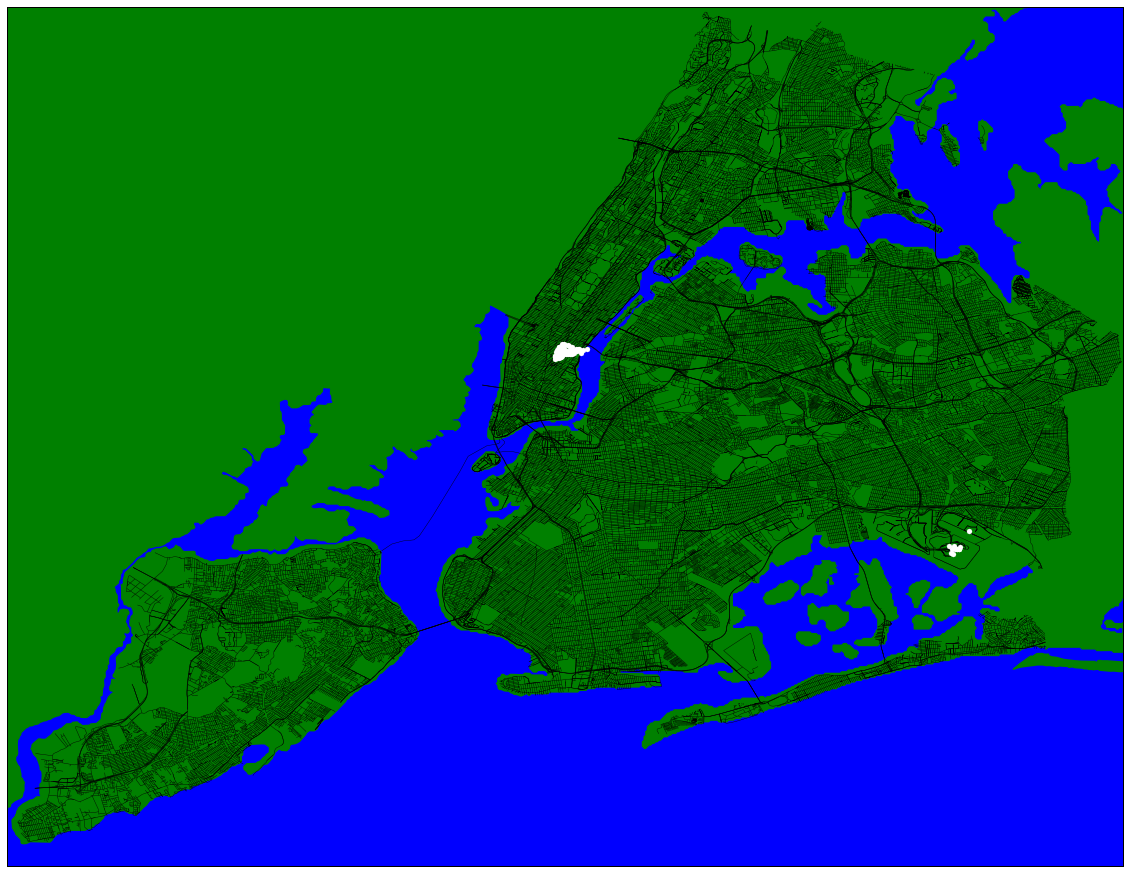

In [287]:
fig = plt.figure(figsize=(20,20))
m.fillcontinents(color='green')
m.drawcountries(linewidth=3)
m.drawrivers()
m.drawmapboundary(fill_color='blue')
ax = fig.add_subplot(1,1,1)
plt.xlim(LOW_LEFT_CORNR_LONGITUDE, UP_RIGHT_CORNER_LONGITUDE)
plt.ylim(LOW_LEFT_CORNER_LATITUDE,UP_RIGHT_CORNER_LATITUDE)
s = m.readshapefile(shapefile='nyc_data_exploration',
                    name='segments', color='black', linewidth=0.4)
ax.scatter(test_lon, test_lat, s = 25,color = 'white',zorder = 2,alpha = 1)

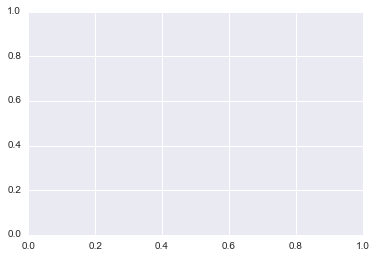

In [289]:
ax = plt.gca()

In [288]:
ax.scatter(test_lon, test_lat, s = 25,color = 'white',zorder = 2,alpha = 1)

In [294]:
from bokeh.io import output_file, show
from bokeh.models import (GMapPlot, GMapOptions, ColumnDataSource, Circle, DataRange1d, PanTool, \
                          WheelZoomTool, BoxSelectTool)

In [306]:
origin_lon = np.mean((LOW_LEFT_CORNR_LONGITUDE,UP_RIGHT_CORNER_LONGITUDE))
origin_lat = np.mean((LOW_LEFT_CORNER_LATITUDE,UP_RIGHT_CORNER_LATITUDE))

In [349]:
map_options = GMapOptions(lat=origin_lat, lng=origin_lon, map_type="roadmap", zoom=10)

plot = GMapPlot(
    x_range=DataRange1d(), y_range=DataRange1d(), map_options=map_options, title="NYC"
)
source = ColumnDataSource(
    data=dict(
        lat=test_lat,
        lon=test_lon,
    )
)
circle = Circle(x="lon", y="lat", size=5, fill_color="blue", fill_alpha=0.8, line_color=None)
plot.add_glyph(source, circle)
plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool())
output_file("gmap_plot.html")
show(plot)

In [320]:
print origin_lat, origin_lon

40.7017495 -73.979793


In [367]:
today = datetime.datetime.today()

In [368]:
today.month

6

In [369]:
today.hour

10

In [371]:
today.weekday()

2